This script builds, trains, and evaluates a nueral network surrogate model to predict the deflection of a beam based on the generated dataset.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time
import random
import os

In [3]:
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # This is a key setting
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# --- 1. Load Data ---
print("Loadind dataset...")
df = pd.read_csv('beam_deflection_dataset.csv')
print("Dataset loaded successfully.")
print("\nDataset Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.info())

Loadind dataset...
Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   k0        5000 non-null   float64
 1   k1        5000 non-null   float64
 2   damping   5000 non-null   int64  
 3   velocity  5000 non-null   float64
 4   w_max     5000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 195.4 KB

First 5 rows of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   k0        5000 non-null   float64
 1   k1        5000 non-null   float64
 2   damping   5000 non-null   int64  
 3   velocity  5000 non-null   float64
 4   w_max     5000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 195.4 KB
None


In [5]:
df

,k0,k1,damping,velocity,w_max
0,3.824946e+07,246086.429205,0,50.137138,0.000163
1,6.500999e+07,197732.221959,0,37.772646,0.000105
2,5.195376e+07,231687.128608,0,44.868033,0.000125
3,5.789096e+07,234723.811707,0,19.353973,0.000113
4,7.587654e+07,242295.458148,0,56.473185,0.000096
...,...,...,...,...,...
4995,1.887662e+07,393712.889839,0,55.014149,0.000279
4996,4.479935e+07,409538.924752,0,54.322664,0.000139
4997,1.172246e+07,222195.994840,0,45.355103,0.000406
4998,7.127523e+07,341784.911735,0,30.620740,0.000098


In [6]:
df.head()

,k0,k1,damping,velocity,w_max
0,3.824946e+07,246086.429205,0,50.137138,0.000163
1,6.500999e+07,197732.221959,0,37.772646,0.000105
2,5.195376e+07,231687.128608,0,44.868033,0.000125
3,5.789096e+07,234723.811707,0,19.353973,0.000113
4,7.587654e+07,242295.458148,0,56.473185,0.000096


In [7]:
df.tail()

,k0,k1,damping,velocity,w_max
4995,1.887662e+07,393712.889839,0,55.014149,0.000279
4996,4.479935e+07,409538.924752,0,54.322664,0.000139
4997,1.172246e+07,222195.994840,0,45.355103,0.000406
4998,7.127523e+07,341784.911735,0,30.620740,0.000098
4999,3.170570e+07,395741.034866,0,15.263256,0.000176


In [8]:
# --- 2. Data Pre-processing ---

# Separate the inpute features (x) from the output target (y).
x = df[['k0', 'k1', 'damping', 'velocity']]
y = df['w_max']

In [9]:
# Split data into training + validation (85%) and testing (15%) sets.
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=RANDOM_SEED)

In [10]:
# Split the 85% block into training (70%) and validation (15%)
# The new test_size is 15/85 to get 15% of the original total data.
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=(0.15/0.85), random_state=RANDOM_SEED)

In [11]:
len(x_train)

3500

In [12]:
len(x_test)

750

In [13]:
# scale the input features
# We fit the scaler ONLY on the training data to prvent data leakage.
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)


In [14]:
print(F"\nData split complete (70/15/15).")
print(F"Total samples: {len(df)}")
print(F"Training samples: {len(x_train)}")
print(F"Validation samples: {len(x_val)}")
print(F"Testing samples: {len(x_test)}")


Data split complete (70/15/15).
Total samples: 5000
Training samples: 3500
Validation samples: 750
Testing samples: 750


In [15]:
# --- 3. Build the Neural Network Model ---
print("\nBuilding and Training the ANN Model...")



Building and Training the ANN Model...


In [16]:
# Input Layer: The shape must match the number of input features (4).
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(x_train_scaled.shape[1],)),
                             
# Deeper and wider architecture
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2), # Add Dropout layer to prevent overfitting
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2), # Add another Dropout layer
    
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(1) # Output layer
])



In [17]:
# Compile the model.
# We define the Optimizer (Adam), Loss function (Mean Squared Error), and any Metrics to track.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [18]:
# Print a summary of the model architecture.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --- 4. Train the Model ---
start_time = time.time()
print("\nTraining the model...")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(x_train_scaled, y_train, epochs=500, validation_data=(x_val_scaled, y_val),
                    batch_size=32, callbacks=[early_stopping], verbose=0)


Training the model...


In [20]:
end_time = time.time()
training_time = end_time - start_time
print(F"\nTraining complete.")
print(F"\nTraining time: {training_time:.2f} seconds.")


Training complete.

Training time: 82.81 seconds.


In [21]:
# --- 5. Evaluate the Model ---
print(F"\nEvaluating the Model on the test set...")


Evaluating the Model on the test set...


In [22]:
# Make predictions on the unseen test data
y_pred = model.predict(x_test_scaled).flatten() # flatten converts a column vector

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
print(y_test.shape)
print(y_pred.shape)
print(x_test_scaled.shape)

(750,)
(750,)
(750, 4)


In [24]:
# Calculate performance metrics.

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [25]:
print("--- Artificial Neural Network Model Performance ---")
print(F"R2 Score: {r2:.4f}")
print(F"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(F"Mean Absolute Error (MAE): {mae:.4f}")

--- Artificial Neural Network Model Performance ---
R2 Score: 0.9422
Root Mean Squared Error (RMSE): 0.0001
Mean Absolute Error (MAE): 0.0000


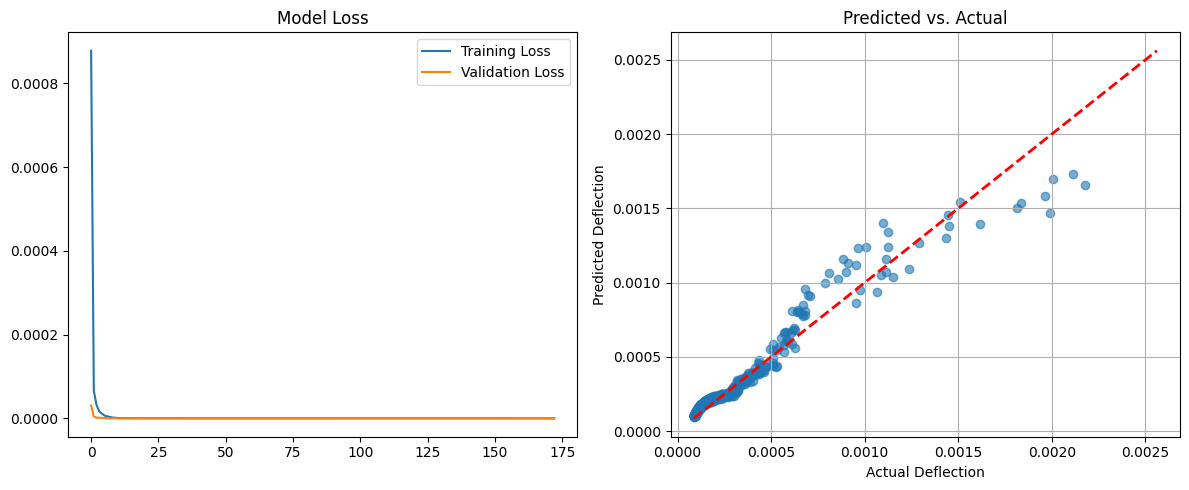

In [26]:
#--- 6. Visualize Results ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Deflection')
plt.ylabel('Predicted Deflection')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# --- 7. Save the Final Model ---
print("\nSaving model...")
model.save('ann_surrogate_model.h5')
print("Model saved successfully as 'ann_surrogate_model.h5'")


Saving model...
Model saved successfully as 'ann_surrogate_model.h5'
